# 1. Import

In [23]:
%reload_ext autoreload
%autoreload 2

In [42]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

from path import path_dict, col_seq_cc, col_seq_elx
import data_process, data_functions, dowhy_methods
import numpy as np
import pandas as pd
from datetime import datetime
from functools import reduce
from sklearn import preprocessing
from datetime import timedelta, datetime
import seaborn as sns
import warnings
from dowhy import CausalModel
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2. Load PMPM Data and Process


In [25]:
#load pmpm data only
_, _, pmpm = data_process.load_data(path_dict)

In [16]:
# --extra -- when doing elx
# pmpm = data_process.elx_pmpm_processing(pmpm.copy())

### 2A. Take log of cost

In [26]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)

# --extra -- when doing elx
# pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
# pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [27]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  CC_ADHD  \
0  2567954  201709        F               95      7.303    0.000   
1  2567954  201802        F               95      0.693    0.000   
2  2567954  201711        F               95      0.693    0.000   
3  2567954  201804        F               96      7.577    0.000   
4  2567954  201707        F               95      4.290    0.000   

   CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0         0.000              0.000   0.000      1.000  ...   
1         0.000              0.000   0.000      0.000  ...   
2         0.000              0.000   0.000      0.000  ...   
3         0.000              0.000   0.000      1.000  ...   
4         0.000              0.000   0.000      1.000  ...   

   CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0               0.000    0.000             0.000                   0.000   
1               0.000    0.000             0.000                   0.000   
2               0.000    0.000             0.000                   0.000   
3               0.000    0.000             0.000                   0.000   
4               0.000    0.000             0.000                   0.000   

   CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  \
0           0.000            0.000      0.000       0.000               0.000   
1           0.000            0.000      0.000       0.000               0.000   
2           0.000            0.000      0.000       0.000               0.000   
3           0.000            0.000      0.000       0.000               0.000   
4           0.000            0.000      0.000       0.000               0.000   

   CC_VISUAL_IMPAIR  
0             0.000  
1             0.000  
2             0.000  
3             0.000  
4             0.000  

[5 rows x 74 columns]

# 3. Training the Deep Neural Network

In [29]:
import data_generator

### 3A. Create Training Feature
col_seq_CC is the sequence of columns when using CC set of features - found in path.py in /modules

In [30]:
train_X = data_generator.generate_data(pmpm, 201701,201712, features=True, col_seq=col_seq_cc)

### 3B. Create Training Labels

In [ ]:
label_cols = ['CC_DIABETES', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION']

In [32]:
train_Y = data_generator.generate_data(pmpm, 201901, 201901, features=False, label_cols=label_cols)

### 3C. Intersect two data sets

In [34]:
train_X, train_Y = data_generator.make_intersection(train_X, train_Y)

### 3D. Creating Test Feature

In [35]:
test_X = data_generator.generate_data(pmpm, 201801,201812, features=True, col_seq=col_seq_cc)

### 3E. Creating Test Labels

In [36]:
test_Y = data_generator.generate_data(pmpm, 202001, 202001, features=False, label_cols=label_cols)

### 3F. Intersect two data sets

In [37]:
test_X, test_Y = data_generator.make_intersection(test_X, test_Y)

### 3G. Define Model Architecture

In [44]:
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import keras_model

In [45]:
#-- extra
baseline_model = keras_model.make_model_4(train_X.shape[1], train_Y.shape[1])

In [46]:
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               9344      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

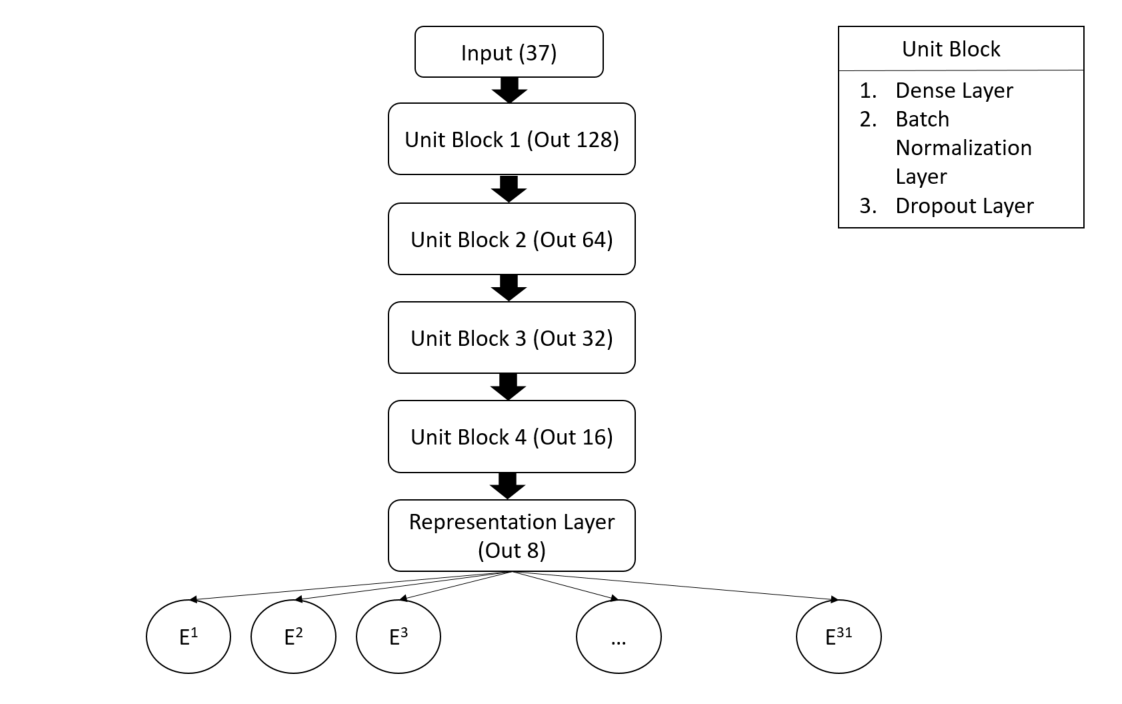

In [47]:
from IPython.display import Image
Image(filename='./images/model3.PNG', width=800, height=800)

### 3H. Model Fit

In [49]:
num_epochs = 20

#use this when branched output heads
#baseline_history = baseline_model.fit(train_X.values, np.hsplit(train_Y.values,train_Y.shape[1]), epochs=num_epochs, validation_split=0.1, batch_size=128, verbose=1)

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_X.values, train_Y.values, epochs=num_epochs, validation_split=0.1, batch_size=128, verbose=1)

Train on 112764 samples, validate on 12530 samples
Epoch 1/20
112764/112764 [==============================] - 5s 40us/step - loss: 0.3428 - acc: 0.8521 - val_loss: 0.2169 - val_acc: 0.9171
Epoch 2/20
112764/112764 [==============================] - 4s 32us/step - loss: 0.2456 - acc: 0.9047 - val_loss: 0.2069 - val_acc: 0.9218
Epoch 3/20
112764/112764 [==============================] - 4s 31us/step - loss: 0.2363 - acc: 0.9106 - val_loss: 0.1996 - val_acc: 0.9273
Epoch 4/20
112764/112764 [==============================] - 4s 31us/step - loss: 0.2308 - acc: 0.9139 - val_loss: 0.1989 - val_acc: 0.9285
Epoch 5/20
112764/112764 [==============================] - 4s 32us/step - loss: 0.2267 - acc: 0.9160 - val_loss: 0.1939 - val_acc: 0.9301
Epoch 6/20
112764/112764 [==============================] - 4s 31us/step - loss: 0.2237 - acc: 0.9177 - val_loss: 0.1921 - val_acc: 0.9315
Epoch 7/20
112764/112764 [==============================] - 4s 31us/step - loss: 0.2222 - acc: 0.9184 - val_loss: 0

In [50]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

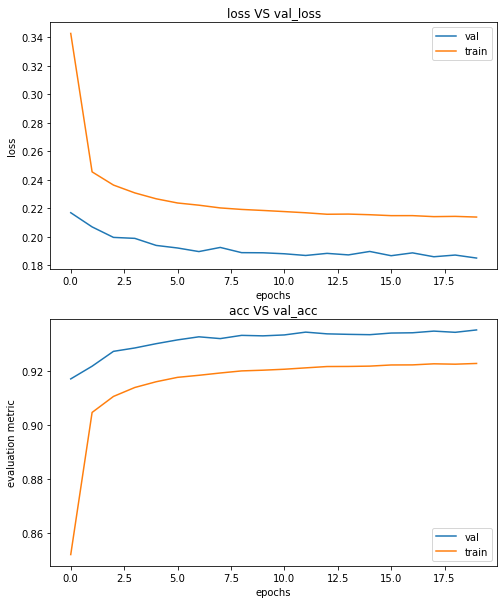

In [54]:
keras_model.plot_history(baseline_history, num_epochs)

In [58]:
#total_loss, b1_loss, b2_loss, b3_loss, b1_metric, b2_metric, b3_metric
print("Training Performance:",baseline_model.evaluate(train_X.values, train_Y.values))
print("Test Performance:",baseline_model.evaluate(test_X.values, test_Y.values))

125294/125294 [==============================] - 2s 20us/step
Training Performance: [0.19694256791481188, 0.9290206779873753]
137176/137176 [==============================] - 3s 20us/step
Test Performance: [0.1947425969622105, 0.9307969516064882]


### 3I. Latent Model upto Representation Layer

In [59]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [60]:
latent_model.predict(train_X).shape

In [61]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

### 3J. Save the Model

In [62]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m4')
latent_model.save('../temp/TF_Latent_Model_m4')

In [64]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m4',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m4',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m4',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m4',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})